In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, RFECV

In [169]:
data_path = '/home/username/Projects/MachineLearning/dataset/500hits.csv'
target_column = 'HOF'
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [170]:
df = pd.read_csv(data_path, encoding='latin-1')

In [171]:
df.head(10)

,PLAYER,YRS,G,AB,R,H,2B,3B,HR,RBI,BB,SO,SB,CS,BA,HOF
0,Ty Cobb,24,3035,11434,2246,4189,724,295,117,726,1249,357,892,178,0.366,1
1,Stan Musial,22,3026,10972,1949,3630,725,177,475,1951,1599,696,78,31,0.331,1
2,Tris Speaker,22,2789,10195,1882,3514,792,222,117,724,1381,220,432,129,0.345,1
3,Derek Jeter,20,2747,11195,1923,3465,544,66,260,1311,1082,1840,358,97,0.310,1
4,Honus Wagner,21,2792,10430,1736,3430,640,252,101,0,963,327,722,15,0.329,1
5,Carl Yastrzemski,23,3308,11988,1816,3419,646,59,452,1844,1845,1393,168,116,0.285,1
6,Paul Molitor,21,2683,10835,1782,3319,605,114,234,1307,1094,1244,504,131,0.306,1
7,Eddie Collins,25,2826,9949,1821,3315,438,187,47,520,1499,286,744,173,0.333,1
8,Willie Mays,22,2992,10881,2062,3283,523,140,660,1903,1464,1526,338,103,0.302,1
9,Eddie Murray,21,3026,11336,1627,3255,560,35,504,1917,1333,1516,110,43,0.287,1


In [172]:
report = []

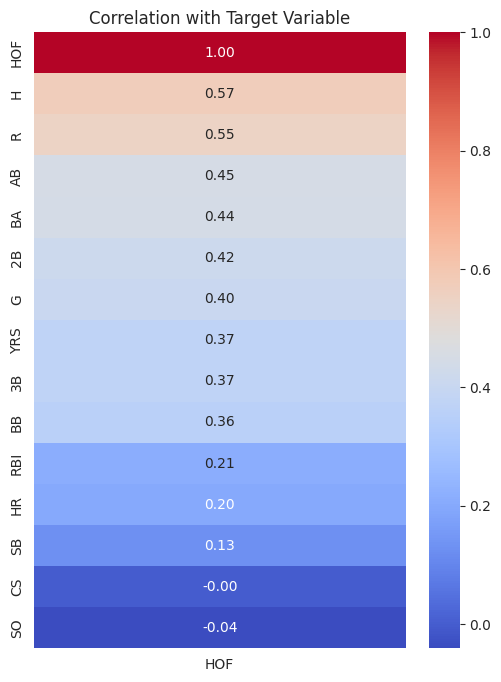

In [173]:

corr_df = df.copy()
corr_df.drop(columns=['PLAYER'], inplace=True)
# let's check correlation with target variable only
correlation = corr_df.corr()
correlation_target = correlation[[target_column]].sort_values(by=target_column, ascending=False)
plt.figure(figsize=(6,8))
sns.heatmap(correlation_target, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation with Target Variable')
plt.show()

In [174]:
X, y = df.drop(columns=['HOF', 'PLAYER']), df['HOF']

# let's add h_bin feature
X['h_bin'] = pd.cut(X['H'], bins=[1000, 2000, 3000, 4200], labels=[1, 2, 3])

In [175]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=X['h_bin'])

In [176]:
X_train = X_train.drop(columns=['h_bin'])
X_test = X_test.drop(columns=['h_bin'])

In [177]:
model = LogisticRegression(max_iter=1000, random_state=42)
estimator = RFE(model, n_features_to_select=12)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", estimator)
])

pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,LogisticRegre...ndom_state=42)
,n_features_to_select,12
,step,1
,verbose,0


In [178]:
test_score = pipeline.score(X_test, y_test)
train_score = pipeline.score(X_train, y_train)

print(f'Train Score: {train_score:.4f}')
print(f'Test Score: {test_score:.4f}')

Train Score: 0.8468
Test Score: 0.8172


In [179]:
train_cv_score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
test_cv_score = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='accuracy')
print(f'Train CV Score: {train_cv_score.mean():.4f} ± {train_cv_score.std():.4f}')
print(f'Test CV Score: {test_cv_score.mean():.4f} ± {test_cv_score.std():.4f}')

/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Train CV Score: 0.8360 ± 0.0365
Test CV Score: 0.8491 ± 0.0631


In [180]:
# check selected features
selected_features = X_train.columns[pipeline['classifier'].support_]
print("Selected features:")
print(selected_features.tolist())
print(f'Total selected features: {len(selected_features)}, df contains {X_train.shape[1]} features')


Selected features:
['YRS', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'SB', 'BA']
Total selected features: 12, df contains 14 features


In [181]:
# let's check classification report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

report.append(
    {
        'method': 'RFE',
        'n_features': len(selected_features),
        'train_score': train_score,
        'test_score': test_score,
        'train_cv_score_mean': train_cv_score.mean(),
        'train_cv_score_std': train_cv_score.std(),
        'test_cv_score_mean': test_cv_score.mean(),
        'test_cv_score_std': test_cv_score.std(),
    }
)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        70
           1       0.65      0.57      0.60        23

    accuracy                           0.82        93
   macro avg       0.76      0.73      0.74        93
weighted avg       0.81      0.82      0.81        93



In [182]:
estimator = RFECV(model, step=1, cv=cv, scoring='accuracy', min_features_to_select=5)

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("classifier", estimator)
])

pipeline.fit(X_train, y_train)

/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,steps,"[('scaler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,estimator,LogisticRegre...ndom_state=42)
,step,1
,min_features_to_select,5
,cv,StratifiedKFo... shuffle=True)


In [183]:
test_score = pipeline.score(X_test, y_test)
train_score = pipeline.score(X_train, y_train)

print(f'Train Score: {train_score:.4f}')
print(f'Test Score: {test_score:.4f}')

train_cv_score = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
test_cv_score = cross_val_score(pipeline, X_test, y_test, cv=cv, scoring='accuracy')
print(f'Train CV Score: {train_cv_score.mean():.4f} ± {train_cv_score.std():.4f}')
print(f'Test CV Score: {test_cv_score.mean():.4f} ± {test_cv_score.std():.4f}')

# check selected features
selected_features = X_train.columns[pipeline['classifier'].support_]
print("Selected features:")
print(selected_features.tolist())
print(f'Total selected features: {len(selected_features)}, df contains {X_train.shape[1]} features')


Train Score: 0.8414
Test Score: 0.8280


/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/model_selecti

Train CV Score: 0.8306 ± 0.0379
Test CV Score: 0.8380 ± 0.0600
Selected features:
['YRS', 'AB', '3B', 'HR', 'RBI', 'SO', 'SB', 'BA']
Total selected features: 8, df contains 14 features


In [184]:
# let's check classification report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89        70
           1       0.67      0.61      0.64        23

    accuracy                           0.83        93
   macro avg       0.77      0.75      0.76        93
weighted avg       0.82      0.83      0.83        93



In [185]:
report.append(
    {
        'method': 'RFECV',
        'n_features': len(selected_features),
        'train_score': train_score,
        'test_score': test_score,
        'train_cv_score_mean': train_cv_score.mean(),
        'train_cv_score_std': train_cv_score.std(),
        'test_cv_score_mean': test_cv_score.mean(),
        'test_cv_score_std': test_cv_score.std(),
    }
)

In [186]:
pipeline = Pipeline([
    ("feature_selection", SelectKBest(score_func=chi2)),
    ('scaler', StandardScaler()),
    ("classifier", model),
])

param_grid = {
    "feature_selection__k": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12 ,13, 14],
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__penalty": ['l2'],
    "classifier__solver": ['lbfgs'],
    "classifier__max_iter": [1000, 2000, 3000],
}

search = GridSearchCV(
    pipeline,
    param_grid,
    # n_iter=15,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    scoring="accuracy",
    n_jobs=-1,
    verbose=0,
    return_train_score=False
)

search.fit(X_train, y_train)

/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__C': [0.01, 0.1, ...], 'classifier__max_iter': [1000, 2000, ...], 'classifier__penalty': ['l2'], 'classifier__solver': ['lbfgs'], ...}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,score_func,<function chi...x7abe5a3a3ce0>


In [187]:
best_model = search.best_estimator_
best_score = search.best_score_
best_params = search.best_params_

In [188]:
test_score = best_model.score(X_test, y_test)
train_score = best_model.score(X_train, y_train)

print(f'Train Score: {train_score:.4f}')
print(f'Test Score: {test_score:.4f}')

train_cv_score = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
test_cv_score = cross_val_score(best_model, X_test, y_test, cv=cv, scoring='accuracy')
print(f'Train CV Score: {train_cv_score.mean():.4f} ± {train_cv_score.std():.4f}') # Train CV Score: 0.8333 ± 0.0529
print(f'Test CV Score: {test_cv_score.mean():.4f} ± {test_cv_score.std():.4f}')    # Test CV Score: 0.8275 ± 0.0801

# check selected features
selected_features = X_train.columns[best_model['feature_selection'].get_support()]
print("Selected features:")
print(selected_features.tolist())
print(f'Total selected features: {len(selected_features)}, df contains {X_train.shape[1]} features')

Train Score: 0.8548
Test Score: 0.8172


/home/username/Projects/MachineLearning/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Train CV Score: 0.8360 ± 0.0554
Test CV Score: 0.8275 ± 0.0801
Selected features:
['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SB', 'CS']
Total selected features: 11, df contains 14 features


In [189]:
# let's check classification report
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        70
           1       0.65      0.57      0.60        23

    accuracy                           0.82        93
   macro avg       0.76      0.73      0.74        93
weighted avg       0.81      0.82      0.81        93



In [190]:
report.append(
    {
        'method': 'SelectKBest + GridSearchCV',
        'n_features': len(selected_features),
        'train_score': train_score,
        'test_score': test_score,
        'train_cv_score_mean': train_cv_score.mean(),
        'train_cv_score_std': train_cv_score.std(),
        'test_cv_score_mean': test_cv_score.mean(),
        'test_cv_score_std': test_cv_score.std(),
    }
)

In [191]:
report_df = pd.DataFrame(report)

report_df.to_csv('rfe_training_report.csv', index=False)